In [1]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import numpy as np
import keras
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from keras.utils.vis_utils import plot_model

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [3]:
    def create_dataset2(dataset, look_back=1):
        dataX, dataY = [], []
        dataZ=[]
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 1]
            dataX.append(a)
            b = dataset[i + look_back, 0]
            dataZ.append(b)
            dataY.append(dataset[i + look_back, 1])
        return numpy.array(dataX), numpy.array(dataY),numpy.array(dataZ)              

In [65]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
# dataframe = read_csv('w_d_v.csv', usecols=[7], engine='python', skipfooter=3)
dataframe = read_csv('t6192.csv', usecols=[8,0], engine='python',dtype=np.int32,skiprows=1,header=None)
pattern = read_csv('t6192.csv', usecols=[7], engine='python',dtype=np.int32,skiprows=1,header=None)
Matrix = read_csv('matrix621.csv', usecols=[2,3,4,5,6,7,8,9,10,11,12,13], engine='python',header=None)
all_data = read_csv('all_data.csv', usecols=[7], engine='python')
dataset = dataframe.values
Matrix = Matrix.values
pattern=pattern.values
allData=all_data.values
Matrix=np.append([[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]],Matrix,axis=0)

week_info = read_csv('t6192.csv', usecols=[11], engine='python',dtype=np.int32,skiprows=1,header=None)
Start_info = read_csv('t6192.csv', usecols=[12], engine='python',dtype=np.int32,skiprows=1,header=None)
End_info = read_csv('t6192.csv', usecols=[13], engine='python',dtype=np.int32,skiprows=1,header=None)
Stay_info = read_csv('t6192.csv', usecols=[14], engine='python',dtype=np.int32,skiprows=1,header=None)
Weather_info = read_csv('t6192.csv', usecols=[15], engine='python',dtype=np.int32,skiprows=1,header=None)

week_info = week_info.values
Start_info = Start_info.values
End_info=End_info.values
Stay_info=Stay_info.values
Weather_info=Weather_info.values

In [66]:
week_info=week_info[3:-1]
Start_info=Start_info[3:-1]
End_info=End_info[2:-2]
Stay_info=Stay_info[2:-2]
Weather_info=Weather_info[3:-1]

In [67]:
print(End_info.shape)
print(Start_info.shape)

(32609, 1)
(32609, 1)


In [68]:
look_back = 3

trainX, trainY, trainZ = create_dataset2(dataset, look_back)
AllX, AllY = create_dataset(allData, look_back)
patternX, patternY = create_dataset(pattern, look_back)

trainY=numpy.reshape(trainY,(trainY.shape[0],-1))
AllY=numpy.reshape(AllY,(AllY.shape[0],-1))



In [69]:
trainY[-10:]
trainX[-10:]
Stay_info[-10:]

array([[ 64],
       [119],
       [ 13],
       [130],
       [  5],
       [167],
       [167],
       [139],
       [167],
       [167]], dtype=int32)

In [72]:
encX = OneHotEncoder()
encX.fit(trainX)
encY = OneHotEncoder()
encY.fit(trainY)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [73]:
trainX_one=encX.transform(trainX).toarray()
train_X=numpy.reshape(trainX_one,(trainX_one.shape[0],look_back,-1))
train_Y=encY.transform(trainY).toarray()

#还没能直接拆分，其他维度没有做对应
a_train, a_test, b_train, b_test = train_test_split(train_X, train_Y, test_size=0.1, random_state=42)

In [74]:
emdedding_size=Matrix.shape[1] #
vo_len=look_back #
vocab_size=Matrix.shape[0] #

In [75]:
a_train=trainX.reshape(-1,3,1)
a_train=a_train.reshape(-1,3)
b_train=train_Y
k=trainZ
k=k.reshape(-1,1)
pretrained_weights=Matrix
LSTM_size=32

print("------------------------")
print("in size:")
print(a_train.shape)
print("------------------------")
print("out size:")
print(b_train.shape)
print("------------------------")
print("user size:")
print(k.shape)
print("------------------------")

In [76]:
N_test=-1
print("------------------------")
print("input semantic example:")
for x in a_train[N_test]:
    print(pretrained_weights[x])
print("------------------------")
print("user_id example:")
print(k[N_test])
print("------------------------")
print("input move pattern example:")
print(a_train[N_test])
print("------------------------")
print("input week_info example:")
print(week_info[N_test])
print("----------------")
print("input Start time example:")
print("Start time sector 4 means 0-6 o'clock in the morning, 3 means 6-9 o'clock in the morning, 2 means 9-17 working hours, 1 means 17-24 points at night +happyHour")
print(Start_info[N_test])
print("----------------")
print("input End time example:")
print(End_info[N_test])
print("----------------")
print("input Stay time example:")
print("per sector means minute")
print(Stay_info[N_test])
print("----------------")
print("input Weather_info example:")
print("1 fog; 2 fog rain; 3 Fog, Rain, Snow; 4 Fog, Rain, Thunderstorm; 5 snow; 6 rain; 7 Thunderstorm; 8 Hail; 9 rain + Thunderstorm; 10 fog + snow; 11 rain + snow")
print(Weather_info[N_test])
print("------------------------")

------------------------
input semantic example:
[0.3220339  0.0338983  0.01694915 0.         0.         0.0338983
 0.         0.06779661 0.30508474 0.08474577 0.13559322 0.        ]
[0.43137255 0.         0.         0.         0.         0.03921569
 0.         0.         0.3529412  0.05882353 0.11764706 0.        ]
[0.3220339  0.0338983  0.01694915 0.         0.         0.0338983
 0.         0.06779661 0.30508474 0.08474577 0.13559322 0.        ]
------------------------
user_id example:
181
------------------------
input move pattern example:
[167 139 167]
------------------------
input week_info example:
[7]
----------------
input Start time example:
Start time sector 4 means 0-6 o'clock in the morning, 3 means 6-9 o'clock in the morning, 2 means 9-17 working hours, 1 means 17-24 points at night +happyHour
[4]
----------------
input End time example:
[4]
----------------
input Stay time example:
per sector means minute
[25]
----------------
input Weather_info example:
1 fog; 2 fog r

In [77]:
print("------------------------")
# print("output encode example:")
# print(b_train[0])
# print("------------------------")

print("output decode example:")
print(trainY[N_test])
print("------------------------")

------------------------
output decode example:
[167]
------------------------


print("------------------------")
print("emdedding_size:")
print(emdedding_size)
print("------------------------")

print("vocab_length:")
print(vo_len)
print("------------------------")

print("vocab_size:")
print(vocab_size)
print("------------------------")

In [134]:
print("使用 T+S+W")
from keras.layers import Input, Embedding, LSTM, Dense,Merge,Flatten
from keras.models import Model
# a_train=a_train.reshape(-1,3)

emdedding_size=100
Location_size=201
User_size=183
LSTM_size=200
Time_size=5
Week_size=8
Stay_size=1440
pretrained_weights_size=12
Weather_type=13

# Move_Pattern Sequences
input_pattern = Input(shape=(3, ),name="Move_Pattern_Input")
# User-Id
User_id = Input(shape=(1,),name="User_id_Input")
# Temporary
Start_Time = Input(shape=(1,),name="Start_Time_Input")
End_Time = Input(shape=(1,),name="End_Time_Input")
Stay_Time = Input(shape=(1,),name="Stay_Time_Input")
Date_Info = Input(shape=(1,),name="Date_Info_Input")#1-7 Monday to Sunday
# Spatial
Location_Info = Input(shape=(3,),name="Semantic_Location_Info_Input")#12 categories  Interest_point

# Weather
Weather_Info = Input(shape=(1,),name="Weather_Info_Input")#1-7 Weather Type

#Spatial
em = Embedding(input_dim=Location_size, output_dim=emdedding_size,input_length=vo_len,name="Spatial_Pattern")(input_pattern)
lstm_out = LSTM(LSTM_size,name="Spatial_Feature")(em)
lstm_out = Dropout(0.2)(lstm_out)

#User_id
User_em = Embedding(input_dim=User_size, output_dim=emdedding_size,input_length=1,name="User_id")(User_id)
User_em=Flatten(name="User_Feature")(User_em)

#Temporary
emStart_Time = Embedding(input_dim=Time_size, output_dim=emdedding_size,input_length=1,name="Start_Time")(Start_Time)
emEnd_Time = Embedding(input_dim=Time_size, output_dim=emdedding_size,input_length=1,name="End_Time")(End_Time)
emStay_Time = Embedding(input_dim=Stay_size, output_dim=emdedding_size,input_length=1,name="Stay_Time")(Stay_Time)
emDate_Info = Embedding(input_dim=Week_size, output_dim=emdedding_size,input_length=1,name="Date_Info")(Date_Info)
Temporary = keras.layers.concatenate([emStart_Time, emEnd_Time,emStay_Time,emDate_Info],name="Temporary_Feature_Model")
Temporary = Flatten(name="Temporary_Feature")(Temporary)

#Semantic
Location_Semantic=Embedding(input_dim=Location_size, output_dim=pretrained_weights_size,input_length=vo_len,weights=[pretrained_weights],name="Semantic_Location_Info")(Location_Info)
Semantic_lstm = LSTM(36,return_sequences=True,name="Semantic_Feature_Model")(Location_Semantic)
Location_Semantic=Flatten(name="Semantic_Feature")(Semantic_lstm)

#Weather
Weather_Em = Embedding(input_dim=Weather_type, output_dim=emdedding_size,input_length=1,name="Weather_info")(Weather_Info)
Weather_Em=Flatten(name="Weather")(Weather_Em)



x = keras.layers.concatenate([lstm_out, User_em, Temporary,Location_Semantic,Weather_Em])
x=Dense(808,activation='relu',name="C")(x)
x=Dense(404,activation='relu',name="C2")(x)
x=Dense(202,activation='relu',name="C3")(x)
x=Dropout(0.2)(x)
x=Dense(b_train.shape[1],activation='softmax',name='x')(x)


model = Model(inputs=[input_pattern,User_id,Start_Time,End_Time,Stay_Time,Date_Info,Location_Info,Weather_Info], outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# print(model.summary()) # Summarize Model
plot_model(model, to_file='t_lstm_T+S+W.png',show_shapes=True)

使用 T+S+W


In [139]:
newc=np.c_[a_train,k,Start_info,End_info,Stay_info,week_info,a_train,Weather_info]
print(newc[:2])

[[167 157 150   0   2   2  38   4 167 157 150   6]
 [157 150 150   0   2   4 980   7 157 150 150   0]]


In [136]:
history_T_S = model.fit([a_train,k,Start_info,End_info,Stay_info,week_info,a_train,Weather_info], b_train, epochs=100, batch_size=512, verbose=2)

Epoch 1/100
 - 6s - loss: 4.4769 - acc: 0.0741
Epoch 2/100
 - 5s - loss: 3.6117 - acc: 0.1915
Epoch 3/100
 - 5s - loss: 3.2341 - acc: 0.2399
Epoch 4/100


KeyboardInterrupt: 

In [109]:
print(trainY[0])
print(np.argmax(b_train[0]))

[150]
146


In [124]:
test=np.asarray([[30,170,145]])
userid=np.asarray([163])
Start_info1=np.asarray([1])
week_info1=np.asarray([5])
End_info1=np.asarray([1])
Stay_info1=np.asarray([85])
Weather_info1=np.asarray([0])

In [125]:
testout=model.predict([test,userid,Start_info1,End_info1,week_info1,test,Weather_info1])
print(np.argmax(testout))

141


In [118]:
print("使用 T+S+W")
from keras.layers import Input, Embedding, LSTM, Dense,Merge,Flatten
from keras.models import Model
# a_train=a_train.reshape(-1,3)

emdedding_size=100
Location_size=201
User_size=183
LSTM_size=200
Time_size=5
Week_size=8
Stay_size=1440
pretrained_weights_size=12
Weather_type=13

# Move_Pattern Sequences
input_pattern = Input(shape=(3, ),name="Move_Pattern_Input")
# User-Id
User_id = Input(shape=(1,),name="User_id_Input")
# Temporary
Start_Time = Input(shape=(1,),name="Start_Time_Input")
End_Time = Input(shape=(1,),name="End_Time_Input")
Stay_Time = Input(shape=(1,),name="Stay_Time_Input")
Date_Info = Input(shape=(1,),name="Date_Info_Input")#1-7 Monday to Sunday
# Spatial
Location_Info = Input(shape=(3,),name="Semantic_Location_Info_Input")#12 categories  Interest_point

# Weather
Weather_Info = Input(shape=(1,),name="Weather_Info_Input")#1-7 Weather Type

#Spatial
em = Embedding(input_dim=Location_size, output_dim=emdedding_size,input_length=vo_len,name="Spatial_Pattern")(input_pattern)
lstm_out = LSTM(LSTM_size,name="Spatial_Feature")(em)
lstm_out = Dropout(0.2)(lstm_out)

#User_id
User_em = Embedding(input_dim=User_size, output_dim=emdedding_size,input_length=1,name="User_id")(User_id)
User_em=Flatten(name="User_Feature")(User_em)

#Temporary
emStart_Time = Embedding(input_dim=Time_size, output_dim=emdedding_size,input_length=1,name="Start_Time")(Start_Time)
emEnd_Time = Embedding(input_dim=Time_size, output_dim=emdedding_size,input_length=1,name="End_Time")(End_Time)
# emStay_Time = Embedding(input_dim=Stay_size, output_dim=emdedding_size,input_length=1,name="Stay_Time")(Stay_Time)
emDate_Info = Embedding(input_dim=Week_size, output_dim=emdedding_size,input_length=1,name="Date_Info")(Date_Info)
Temporary = keras.layers.concatenate([emStart_Time, emEnd_Time,emDate_Info],name="Temporary_Feature_Model")
Temporary = Flatten(name="Temporary_Feature")(Temporary)

#Semantic
Location_Semantic=Embedding(input_dim=Location_size, output_dim=pretrained_weights_size,input_length=vo_len,weights=[pretrained_weights],name="Semantic_Location_Info")(Location_Info)
Semantic_lstm = LSTM(36,return_sequences=True,name="Semantic_Feature_Model")(Location_Semantic)
Location_Semantic=Flatten(name="Semantic_Feature")(Semantic_lstm)

#Weather
Weather_Em = Embedding(input_dim=Weather_type, output_dim=emdedding_size,input_length=1,name="Weather_info")(Weather_Info)
Weather_Em=Flatten(name="Weather")(Weather_Em)



x = keras.layers.concatenate([lstm_out, User_em, Temporary,Location_Semantic,Weather_Em])
x=Dense(808,activation='relu',name="C")(x)
x=Dense(404,activation='relu',name="C2")(x)
x=Dense(202,activation='relu',name="C3")(x)
x=Dropout(0.2)(x)
x=Dense(b_train.shape[1],activation='softmax',name='x')(x)


model = Model(inputs=[input_pattern,User_id,Start_Time,End_Time,Date_Info,Location_Info,Weather_Info], outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# print(model.summary()) # Summarize Model
plot_model(model, to_file='t_lstm_T+S+W.png',show_shapes=True)

使用 T+S+W


In [123]:
history_T_S_W = model.fit([a_train,k,Start_info,End_info,week_info,a_train,Weather_info], b_train, epochs=100, batch_size=512, verbose=2)

Epoch 1/100
 - 5s - loss: 2.4706 - acc: 0.3612
Epoch 2/100
 - 5s - loss: 2.4130 - acc: 0.3692
Epoch 3/100
 - 5s - loss: 2.3757 - acc: 0.3756
Epoch 4/100
 - 5s - loss: 2.3209 - acc: 0.3854
Epoch 5/100
 - 5s - loss: 2.2613 - acc: 0.3976
Epoch 6/100
 - 5s - loss: 2.2109 - acc: 0.4049
Epoch 7/100
 - 5s - loss: 2.1631 - acc: 0.4105
Epoch 8/100
 - 5s - loss: 2.1071 - acc: 0.4233
Epoch 9/100
 - 5s - loss: 2.0529 - acc: 0.4347
Epoch 10/100
 - 5s - loss: 2.0051 - acc: 0.4448
Epoch 11/100
 - 5s - loss: 1.9416 - acc: 0.4554
Epoch 12/100
 - 5s - loss: 1.8828 - acc: 0.4689
Epoch 13/100
 - 5s - loss: 1.8206 - acc: 0.4813
Epoch 14/100
 - 5s - loss: 1.7587 - acc: 0.4913
Epoch 15/100
 - 5s - loss: 1.7009 - acc: 0.5062
Epoch 16/100
 - 5s - loss: 1.6307 - acc: 0.5220
Epoch 17/100
 - 5s - loss: 1.5675 - acc: 0.5381
Epoch 18/100
 - 5s - loss: 1.5152 - acc: 0.5514
Epoch 19/100
 - 5s - loss: 1.4550 - acc: 0.5618
Epoch 20/100
 - 5s - loss: 1.3893 - acc: 0.5803
Epoch 21/100
 - 5s - loss: 1.3240 - acc: 0.5945
E

KeyboardInterrupt: 

In [52]:
print("使用 encode2 (语义权重 pretrained_weights)方法")
from keras.layers import Input, Embedding, LSTM, Dense,Merge,Flatten
from keras.models import Model
# a_train=a_train.reshape(-1,3)

emdedding_size=100
Location_size=201
User_size=183
LSTM_size=200
Time_size=5
Week_size=8
Stay_size=1440

# Move_Pattern Sequences
input_pattern = Input(shape=(3, ),name="Move_Pattern")
# User-Id
User_id = Input(shape=(1,),name="User_id")
# Temporary
Start_Time = Input(shape=(1,),name="Start_Time")
End_Time = Input(shape=(1,),name="End_Time")
Stay_Time = Input(shape=(1,),name="Stay_Time")
Date_Info = Input(shape=(1,),name="Date_Info")#1-7 Monday to Sunday
# Spatial
Location_Info = Input(shape=(12,),name="Location_Info")#12 categories  Interest_point
# Weather
Weather_Info = Input(shape=(1,),name="Weather_Info")#1-7 Weather Type


em = Embedding(input_dim=Location_size, output_dim=emdedding_size,input_length=vo_len)(input_pattern)
lstm_out = LSTM(LSTM_size)(em)
lstm_out = Dropout(0.2)(lstm_out)

em2 = Embedding(input_dim=User_size, output_dim=emdedding_size,input_length=1)(User_id)

emStart_Time = Embedding(input_dim=Time_size, output_dim=emdedding_size,input_length=1)(Start_Time)
emEnd_Time = Embedding(input_dim=Time_size, output_dim=emdedding_size,input_length=1)(End_Time)
emStay_Time = Embedding(input_dim=Stay_size, output_dim=emdedding_size,input_length=1)(Stay_Time)
emDate_Info = Embedding(input_dim=Week_size, output_dim=emdedding_size,input_length=1)(Date_Info)

Temporary = keras.layers.concatenate([emStart_Time, emEnd_Time,emStay_Time,emDate_Info])
Temporary = Flatten()(Temporary)


em2=Flatten()(em2)

x = keras.layers.concatenate([lstm_out, em2, Temporary])
x=Dense(700,activation='relu',name="C")(x)
x=Dense(400,activation='relu',name="C2")(x)
x=Dense(250,activation='relu',name="C3")(x)
x=Dropout(0.2)(x)
x=Dense(b_train.shape[1],activation='softmax',name='x')(x)


model = Model(inputs=[input_pattern,User_id,Start_Time,End_Time,Stay_Time,Date_Info], outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# print(model.summary()) # Summarize Model
plot_model(model, to_file='t_lstm624.png',show_shapes=True)

使用 encode2 (语义权重 pretrained_weights)方法


In [54]:
history_nopre = model.fit([a_train,k,Start_info,End_info,Stay_info,week_info], b_train, epochs=100, batch_size=512, verbose=2)

Epoch 1/100
 - 5s - loss: 4.5151 - acc: 0.0695
Epoch 2/100
 - 4s - loss: 3.6527 - acc: 0.1808
Epoch 3/100
 - 4s - loss: 3.2736 - acc: 0.2294
Epoch 4/100
 - 4s - loss: 3.0785 - acc: 0.2548
Epoch 5/100
 - 4s - loss: 2.9331 - acc: 0.2816
Epoch 6/100
 - 4s - loss: 2.8254 - acc: 0.3030
Epoch 7/100
 - 4s - loss: 2.7225 - acc: 0.3212
Epoch 8/100
 - 4s - loss: 2.6440 - acc: 0.3354
Epoch 9/100
 - 4s - loss: 2.5695 - acc: 0.3478
Epoch 10/100
 - 4s - loss: 2.4987 - acc: 0.3633
Epoch 11/100
 - 4s - loss: 2.4260 - acc: 0.3776
Epoch 12/100
 - 4s - loss: 2.3638 - acc: 0.3881
Epoch 13/100
 - 4s - loss: 2.3012 - acc: 0.4041
Epoch 14/100
 - 4s - loss: 2.2367 - acc: 0.4136
Epoch 15/100
 - 4s - loss: 2.1730 - acc: 0.4289
Epoch 16/100
 - 4s - loss: 2.1138 - acc: 0.4398
Epoch 17/100
 - 4s - loss: 2.0453 - acc: 0.4566
Epoch 18/100
 - 4s - loss: 1.9823 - acc: 0.4705
Epoch 19/100
 - 4s - loss: 1.9170 - acc: 0.4845
Epoch 20/100
 - 4s - loss: 1.8601 - acc: 0.4936
Epoch 21/100
 - 4s - loss: 1.7918 - acc: 0.5095
E

In [61]:
print("使用 encode2 (语义权重 pretrained_weights)方法")
from keras.layers import Input, Embedding, LSTM, Dense,Merge,Flatten
from keras.models import Model
# a_train=a_train.reshape(-1,3)

emdedding_size=100
Location_size=201
User_size=183
LSTM_size=200
Time_size=5
Week_size=8
Stay_size=1440

# Move_Pattern Sequences
input_pattern = Input(shape=(3, ),name="Move_Pattern")
# User-Id
User_id = Input(shape=(1,),name="User_id")
# Temporary
Start_Time = Input(shape=(1,),name="Start_Time")
End_Time = Input(shape=(1,),name="End_Time")
Stay_Time = Input(shape=(1,),name="Stay_Time")
Date_Info = Input(shape=(1,),name="Date_Info")#1-7 Monday to Sunday
# Spatial
Location_Info = Input(shape=(12,),name="Location_Info")#12 categories  Interest_point
# Weather
Weather_Info = Input(shape=(1,),name="Weather_Info")#1-7 Weather Type


em = Embedding(input_dim=Location_size, output_dim=emdedding_size,input_length=vo_len)(input_pattern)
lstm_out = LSTM(LSTM_size)(em)
lstm_out = Dropout(0.2)(lstm_out)

em2 = Embedding(input_dim=User_size, output_dim=emdedding_size,input_length=1)(User_id)

emStart_Time = Embedding(input_dim=Time_size, output_dim=emdedding_size,input_length=1)(Start_Time)
emEnd_Time = Embedding(input_dim=Time_size, output_dim=emdedding_size,input_length=1)(End_Time)
emStay_Time = Embedding(input_dim=Stay_size, output_dim=emdedding_size,input_length=1)(Stay_Time)
emDate_Info = Embedding(input_dim=Week_size, output_dim=emdedding_size,input_length=1)(Date_Info)

# Temporary = keras.layers.concatenate([emStart_Time, emEnd_Time,emStay_Time,emDate_Info])
# Temporary = Flatten()(Temporary)


em2=Flatten()(em2)

x = keras.layers.concatenate([lstm_out, em2])
x=Dense(700,activation='relu',name="C")(x)
x=Dense(400,activation='relu',name="C2")(x)
x=Dense(250,activation='relu',name="C3")(x)
x=Dropout(0.2)(x)
x=Dense(b_train.shape[1],activation='softmax',name='x')(x)


model = Model(inputs=[input_pattern,User_id,Start_Time,End_Time,Stay_Time,Date_Info], outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# print(model.summary()) # Summarize Model
plot_model(model, to_file='t_lstm624_notem.png',show_shapes=True)
history_notem = model.fit([a_train,k,Start_info,End_info,Stay_info,week_info], b_train, epochs=100, batch_size=512, verbose=2)

使用 encode2 (语义权重 pretrained_weights)方法
Epoch 1/100
 - 5s - loss: 4.4098 - acc: 0.0946
Epoch 2/100
 - 4s - loss: 3.5862 - acc: 0.1948
Epoch 3/100
 - 4s - loss: 3.2489 - acc: 0.2342
Epoch 4/100
 - 4s - loss: 3.0829 - acc: 0.2527
Epoch 5/100
 - 4s - loss: 2.9850 - acc: 0.2709
Epoch 6/100
 - 4s - loss: 2.9109 - acc: 0.2798
Epoch 7/100
 - 4s - loss: 2.8564 - acc: 0.2916
Epoch 8/100
 - 4s - loss: 2.8051 - acc: 0.3000
Epoch 9/100
 - 4s - loss: 2.7660 - acc: 0.3041
Epoch 10/100
 - 4s - loss: 2.7346 - acc: 0.3113
Epoch 11/100
 - 4s - loss: 2.7005 - acc: 0.3153
Epoch 12/100
 - 4s - loss: 2.6724 - acc: 0.3184
Epoch 13/100
 - 4s - loss: 2.6443 - acc: 0.3258
Epoch 14/100
 - 4s - loss: 2.6169 - acc: 0.3250
Epoch 15/100
 - 4s - loss: 2.5882 - acc: 0.3295
Epoch 16/100
 - 4s - loss: 2.5637 - acc: 0.3382
Epoch 17/100
 - 4s - loss: 2.5374 - acc: 0.3366
Epoch 18/100
 - 4s - loss: 2.5117 - acc: 0.3431
Epoch 19/100
 - 4s - loss: 2.4897 - acc: 0.3464
Epoch 20/100
 - 4s - loss: 2.4642 - acc: 0.3504
Epoch 21/1

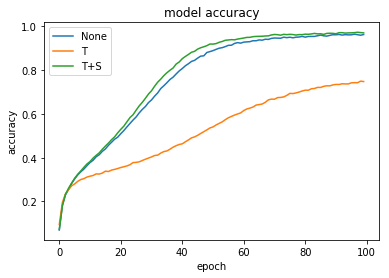

In [89]:
fig = plt.figure()
plt.plot(history_nopre.history['acc'])
plt.plot(history_notem.history['acc'])
plt.plot(history_T_S.history['acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['None', 'T','T+S'], loc='upper left')

In [28]:
print("使用 encode1 方法")
aa_train=train_X

from keras.layers import Input, Embedding, LSTM, Dense,Merge
from keras.models import Model

input_pattern = Input(shape=(3, aa_train.shape[2]),name="Move_Pattern")
input_id = Input(shape=(1,),name="User_id")

lstm_out = LSTM(units=200,return_sequences=False)(input_pattern)
lstm_out = Dropout(0.2)(lstm_out)

em2 = Embedding(input_dim=User_size, output_dim=emdedding_size,input_length=1)(input_id)
em2=Flatten()(em2)

x = keras.layers.concatenate([lstm_out, em2])
x=Dense(400,activation='relu',name="C")(x)
x=Dense(300,activation='relu',name="C2")(x)
x=Dense(250,activation='relu',name="C3")(x)
x=Dropout(0.2)(x)
x=Dense(b_train.shape[1],activation='softmax')(x)


model = Model(inputs=[input_pattern,input_id], outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# print(model.summary()) # Summarize Model
plot_model(model, to_file='t_lstm_encode1.png',show_shapes=True)

使用 encode1 方法


In [29]:
history_encode1 = model.fit([aa_train,k], b_train, epochs=100, batch_size=512, verbose=2)

Epoch 1/100
 - 4s - loss: 4.4523 - acc: 0.0925
Epoch 2/100
 - 3s - loss: 3.6074 - acc: 0.1954
Epoch 3/100
 - 3s - loss: 3.2661 - acc: 0.2316
Epoch 4/100
 - 3s - loss: 3.0907 - acc: 0.2558
Epoch 5/100
 - 3s - loss: 2.9844 - acc: 0.2712
Epoch 6/100
 - 3s - loss: 2.9094 - acc: 0.2850
Epoch 7/100
 - 3s - loss: 2.8517 - acc: 0.2902
Epoch 8/100
 - 3s - loss: 2.8035 - acc: 0.2990
Epoch 9/100
 - 3s - loss: 2.7607 - acc: 0.3067
Epoch 10/100
 - 3s - loss: 2.7275 - acc: 0.3122
Epoch 11/100
 - 3s - loss: 2.6969 - acc: 0.3147
Epoch 12/100
 - 3s - loss: 2.6657 - acc: 0.3205
Epoch 13/100
 - 3s - loss: 2.6371 - acc: 0.3258
Epoch 14/100
 - 3s - loss: 2.6091 - acc: 0.3308
Epoch 15/100
 - 3s - loss: 2.5838 - acc: 0.3344
Epoch 16/100
 - 3s - loss: 2.5607 - acc: 0.3383
Epoch 17/100
 - 3s - loss: 2.5401 - acc: 0.3419
Epoch 18/100
 - 3s - loss: 2.5118 - acc: 0.3459
Epoch 19/100
 - 3s - loss: 2.4928 - acc: 0.3492
Epoch 20/100
 - 3s - loss: 2.4602 - acc: 0.3539
Epoch 21/100
 - 3s - loss: 2.4381 - acc: 0.3582
E

In [25]:
aa_train=train_X

from keras.layers import Input, Embedding, LSTM, Dense,Merge
from keras.models import Model

input_pattern = Input(shape=(3, aa_train.shape[2]),name="Move_Pattern")
input_id = Input(shape=(1,),name="User_id")

lstm_out = LSTM(units=300,return_sequences=False)(input_pattern)
lstm_out = Dropout(0.2)(lstm_out)

# em2 = Embedding(input_dim=User_size, output_dim=emdedding_size,input_length=1)(input_id)
# em2=Flatten()(em2)

# x = keras.layers.concatenate([lstm_out, em2])
x=Dense(400,activation='relu',name="C1")(lstm_out)
x=Dense(300,activation='relu',name="C2")(x)
x=Dense(250,activation='relu',name="C3")(x)
x=Dropout(0.2)(x)
x=Dense(b_train.shape[1],activation='softmax')(x)


model = Model(inputs=[input_pattern,input_id], outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# print(model.summary()) # Summarize Model
plot_model(model, to_file='t_lstm_encode1.png',show_shapes=True)

In [27]:
history_encode1 = model.fit([aa_train,k], b_train, epochs=100, batch_size=512, verbose=2)

Epoch 1/100
 - 5s - loss: 2.7515 - acc: 0.3074
Epoch 2/100
 - 5s - loss: 2.7160 - acc: 0.3114
Epoch 3/100
 - 5s - loss: 2.7005 - acc: 0.3157
Epoch 4/100
 - 5s - loss: 2.6906 - acc: 0.3139
Epoch 5/100
 - 5s - loss: 2.6715 - acc: 0.3190
Epoch 6/100
 - 5s - loss: 2.6571 - acc: 0.3207
Epoch 7/100
 - 5s - loss: 2.6453 - acc: 0.3226
Epoch 8/100
 - 5s - loss: 2.6285 - acc: 0.3247
Epoch 9/100
 - 5s - loss: 2.6126 - acc: 0.3291
Epoch 10/100
 - 5s - loss: 2.5998 - acc: 0.3298
Epoch 11/100
 - 5s - loss: 2.5840 - acc: 0.3312
Epoch 12/100
 - 5s - loss: 2.5704 - acc: 0.3353
Epoch 13/100
 - 5s - loss: 2.5506 - acc: 0.3393
Epoch 14/100
 - 5s - loss: 2.5368 - acc: 0.3394
Epoch 15/100
 - 5s - loss: 2.5159 - acc: 0.3440
Epoch 16/100
 - 5s - loss: 2.4993 - acc: 0.3461
Epoch 17/100
 - 5s - loss: 2.4865 - acc: 0.3480
Epoch 18/100
 - 5s - loss: 2.4604 - acc: 0.3496
Epoch 19/100
 - 5s - loss: 2.4475 - acc: 0.3515
Epoch 20/100
 - 5s - loss: 2.4198 - acc: 0.3601
Epoch 21/100
 - 5s - loss: 2.4056 - acc: 0.3603
E

KeyboardInterrupt: 

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense,Merge
from keras.models import Model

emdedding_size=12 #
vo_len=3 #
vocab_size=11000 #
a_train=patternX
b_train=train_Y
k=trainZ
pretrained_weights=Matrix

input_pattern = Input(shape=(3, ),name="input_pattern")
em = Embedding(input_dim=vocab_size, output_dim=emdedding_size,input_length=vo_len, weights=[pretrained_weights])(input_pattern)
lstm_out = LSTM(units=emdedding_size)(em)
lstm_out = Dropout(0.2)(lstm_out)

x=Dense(250,activation='relu',name="C")(lstm_out)
x=Dropout(0.2)(x)
x=Dense(180,activation='softmax')(x)


model = Model(inputs=input_pattern, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print(model.summary()) # Summarize Model
plot_model(model, to_file='t_lstm_test.png',show_shapes=True)
history_withpre2 = model.fit(a_train, b_train, epochs=100, batch_size=16, verbose=2)

plot_model(model, to_file='t_lstm_test.png',show_shapes=True)
history_nopre = model.fit(a_train, b_train, epochs=100, batch_size=16, verbose=2)

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense,Merge
from keras.models import Model

emdedding_size=12 #
vo_len=3 #
vocab_size=11000 #
a_train=trainX.reshape(-1,3)
b_train=train_Y
k=trainZ
pretrained_weights=Matrix

input_pattern = Input(shape=(3, ),name="input_pattern")
em = Embedding(input_dim=vocab_size, output_dim=emdedding_size,input_length=vo_len, weights=[pretrained_weights])(input_pattern)
lstm_out = LSTM(units=emdedding_size)(em)
lstm_out = Dropout(0.2)(lstm_out)

x=Dense(250,activation='relu',name="C")(lstm_out)
x=Dropout(0.2)(x)
x=Dense(180,activation='softmax')(x)


model = Model(inputs=input_pattern, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print(model.summary()) # Summarize Model
plot_model(model, to_file='t_lstm_test.png',show_shapes=True)
history_withpre2 = model.fit(a_train, b_train, epochs=100, batch_size=16, verbose=2)

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense,Merge
from keras.models import Model

emdedding_size=12 #
vo_len=3 #
vocab_size=11000 #
a_train=patternX.reshape(-1,3,1)
b_train=train_Y
k=trainZ
pretrained_weights=Matrix

input_pattern = Input(shape=(3, 1),name="input_pattern")
lstm_out = LSTM(units=64)(input_pattern)
lstm_out = Dropout(0.2)(lstm_out)

x=Dense(250,activation='relu',name="C")(lstm_out)
x=Dropout(0.2)(x)
x=Dense(180,activation='softmax')(x)


model = Model(inputs=input_pattern, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print(model.summary()) # Summarize Model
plot_model(model, to_file='t_lstm_test.png',show_shapes=True)
history_withpre2 = model.fit(a_train, b_train, epochs=100, batch_size=16, verbose=2)

plot_model(model, to_file='t_lstm_test.png',show_shapes=True)
history1 = model.fit(a_train, b_train, epochs=100, batch_size=16, verbose=2)

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense,Merge
from keras.models import Model

input_pattern = Input(shape=(3, a_train.shape[2]),name="input_pattern")

lstm_out = LSTM(512,input_shape=(3, a_train.shape[2]))(input_pattern)
# lstm_out = LSTM(512,return_sequences=True,input_shape=(3, a_train.shape[2]))(input_pattern)
# lstm_out = LSTM(300)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)

x=Dense(250,activation='relu',name="C")(lstm_out)
x=Dropout(0.2)(x)
x=Dense(a_train.shape[2],activation='softmax')(x)

model = Model(inputs=input_pattern, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print(model.summary()) # Summarize Model
plot_model(model, to_file='t_lstm_test.png',show_shapes=True)

In [ ]:
history = model.fit(a_train, b_train, epochs=100, batch_size=16, verbose=2, validation_data=(a_test, b_test))

In [ ]:
print(history.history.keys())

In [ ]:
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history1.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['1-lstm', '2-lstm'], loc='upper left')

In [ ]:
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')

In [ ]:
train_X=train_X.reshape(-1,200)
train_Y.reshape(-1,200)
train_X.shape

In [ ]:
train_Y.shape

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense,Merge
from keras.models import Model

a_train=train_X
b_train=train_Y
k=trainZ

input_pattern = Input(shape=(3, a_train.shape[2]),name="input_pattern")
input_id = Input(shape=(1,),name="input_id")

lstm_out = LSTM(250,input_shape=(3, a_train.shape[2]))(input_pattern)
lstm_out = Dropout(0.2)(lstm_out)

x = keras.layers.concatenate([lstm_out, input_id])
x=Dense(250,activation='relu',name="C")(x)
x=Dropout(0.2)(x)
x=Dense(a_train.shape[2],activation='softmax',name='x')(x)


model = Model(inputs=[input_pattern,input_id], outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print(model.summary()) # Summarize Model
plot_model(model, to_file='t_lstm.png',show_shapes=True)

In [ ]:
k=np.zeros(a_train.shape[0],dtype=np.int16)
k=k.reshape(-1,1)

k1=np.zeros(train_X.shape[0],dtype=np.int16)
k1=k1.reshape(-1,1)

In [ ]:
history = model.fit({'input_pattern': a_train, 'input_id' : k}, {'x': b_train}, epochs=100, batch_size=64, verbose=2)

In [ ]:
fig = plt.figure()
Accuracy=[42.00,47.15 ,48.36, 49.35,47.42, 50.82, 52.31,56.93 ,57.15 ]
x2=(20,30,40,50,60,70,80,90,100)
plt.plot(x2,Accuracy)
x1=range(0,100)
plt.plot(x1,history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['100% total_data Yu','100% total_data Mine'], loc='upper left')



In [ ]:
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['90% train_data', '100% total_data'], loc='upper left')

model.fit(a_train, b_train, epochs=100, batch_size=16, verbose=2, validation_data=(a_test, b_test))

In [ ]:
model.evaluate(train_X, train_Y, batch_size=64, verbose=2, sample_weight=None)

In [ ]:
trainPredict = model.predict(train_X)
D=np.argmax(train_Y,axis = 1)
E=np.argmax(trainPredict,axis = 1)

In [ ]:
print(D)
print(E)

In [ ]:
A=0 #total number of right
for i,t in enumerate(E):
    if D[i]==t :
        A=A+1
print(A/D.shape[0])